In [2]:
# coding: utf-8

# # NDAI calculation process
# This process intend to calculate the Vegetation Condition index (VCI) for a specific area. The fomula of the index is:
# NDAI =a*NVAI-(1-a)*NTAI, where a is 0.5
# where the NDAI is Normalized Droguht Anomaly Index.
# This is a WPS process served by PyWPS.
#
# Input:
# bBox:a rectangle box which specifies the processing area.
# date: a date string specifies the date to be calculated. The date format should be "YYYY-MM-DD".
#
# Output:
# file:
# format:
#
# The process internally retrieves NDVI data set from a rasdaman database.
#
# Client side execute script:
# http://localhost/cgi-bin/wpswsgi?service=wps&version=1.0.0&request=execute&identifier=WPS_NDAI_DI_CAL&datainputs=[date=2005-02-06;bbox=50,10,120,60]&responsedocument=image=@asReference=true


# coding: utf-8

# In[ ]:

#from pywps.Process import WPSProcess 
import logging
import os
import sys
import urllib
from lxml import etree
from osgeo import gdal
import numpy as np
import numpy
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import json
import types
#import geojson
import subprocess as sp
import json
import pandas as pd
from cStringIO import StringIO


In [3]:
def GetCoverageNames():
    file_json = r'D:\Downloads\Mattijn@Zhou\coverages_names.json'
    with open(file_json) as json_data:
        d = json.load(json_data)
    _CoverageID_NDVI = d['COVG_NAME_NDVI_MOD13C1005']
    _CoverageID_LST  = d['COVG_NAME_LST_MOD11C2005']
    return _CoverageID_NDVI, _CoverageID_LST

# In[ ]:

In [4]:
def datelist_regular_cov(root, start_date, start, cur_date):
    """
    retrieve regular datelist and requested current position in regards to total no. of observations
    """

    #print start
    tmp_date=datetime(start.year,cur_date.month,cur_date.day)
    if tmp_date > start :
        start=(tmp_date-datetime(1601,1,1)).days
    else: start=(datetime(start.year+1,cur_date.month,cur_date.day)-datetime(1601,1,1)).days
    datelist=range(start+1,end_date-1,365)
    print datelist
    logging.info(datelist)

    #find the position of the requested date in the datelist
    cur_epoch=(cur_date-datetime(1601,1,1)).days
    cur_pos=min(range(len(datelist)),key=lambda x:abs(datelist[x]-cur_epoch))
    print ('Current position:',cur_pos)    
    
    return datelist, cur_pos

# In[ ]:

In [5]:
def datelist_irregular_cov(root, start_date, start, cur_date):
    """
    retrieve irregular datelist and requested current position in regards to total no. of observations
    """
    
    #root[0]                - wcs:CoverageDescription
    #root[0][0]             - boundedBy 
    #root[0][0][0]          - Envelope
    #root[0][0][0][0]       - lowerCorner
    # --- 
    #root[0]                - wcs:CoverageDescription
    #root[0][3]             - domainSet
    #root[0][3][0]          - gmlrgrid:ReferenceableGridByVectors
    #root[0][3][0][5]       - gmlrgrid:generalGridAxis
    #root[0][3][0][5][0]    - gmlrgrid:GeneralGridAxis
    #root[0][3][0][5][0][1] - gmlrgrid:coefficients

    # get sample size coefficients from XML root
    sample_size = root[0][3][0][5][0][1].text #sample size
    #print root[0][3][0][5][0][1].text #sample size
    
    # use coverage start_date and sample_size array to create all dates in ANSI
    array_stepsize = np.fromstring(sample_size, dtype=int, sep=' ')
    #print np.fromstring(sample_size, dtype=int, sep=' ')
    array_all_ansi = array_stepsize + start_date   
    
    # create array of all dates in ISO
    list_all_dates = []
    for stepsize in array_stepsize:
        date_and_stepsize = start + timedelta(stepsize - 1)
        list_all_dates.append(date_and_stepsize)
        #print date_and_stepsize
    array_all_dates = np.array(list_all_dates)  
    
    # create array of all dates as DOY
    list_all_yday = []
    for j in array_all_dates:
        yday = j.timetuple().tm_yday
        list_all_yday.append(yday)
        #print yday
    array_all_yday = np.array(list_all_yday)    
    
    # subtract user date of all dates in ISO 
    # to find the nearest available coverage date
    array_diff_dates = array_all_dates - cur_date
    idx_nearest_date = find_nearest(array_diff_dates, timedelta(0))
    nearest_date = array_all_dates[idx_nearest_date]    
    
    # select all coresponding DOY of all years for ANSI and ISO dates
    array_selected_ansi = array_all_ansi[array_all_yday == nearest_date.timetuple().tm_yday]
    array_selected_dates = array_all_dates[array_all_yday == nearest_date.timetuple().tm_yday]
    print array_selected_ansi
    logging.info(array_selected_ansi)
    
    # get index of nearest date in selection array
    idx_nearest_date_selected = numpy.where(array_selected_dates==nearest_date)[0][0]  
    print idx_nearest_date_selected
    
    # return datelist in ANSI and the index of the nearest date
    return array_selected_ansi, idx_nearest_date_selected

# In[ ]:

In [6]:
def find_nearest(array,value):
    return (np.abs(array-value)).argmin()

# In[ ]:

In [7]:
def datelist_irregular_coverage(root, date, no_observations):
    #get ANSI start date of coverage
    lc = root.find(".//{http://www.opengis.net/gml/3.2}lowerCorner").text
    start_date=int((lc.split(' '))[2])
    #print [start_date, end_date]

    #convert user date to ISO date
    cur_date = datetime.strptime(date,"%Y-%m-%d")
    #convert start date coverage to ISO date
    start = datetime.fromtimestamp((start_date-(datetime(1970,1,1)-datetime(1601,1,1)).days)*24*60*60)
    #print start    

    # get sample size coefficients from XML root
    sample_size = root[0][3][0][5][0][1].text #sample size
    #print root[0][3][0][5][0][1].text #sample size
    
    # use coverage start_date and sample_size array to create all dates in ANSI
    array_stepsize = np.fromstring(sample_size, dtype=int, sep=' ')
    #print np.fromstring(sample_size, dtype=int, sep=' ')
    array_all_ansi = array_stepsize + start_date   
    
    # create array of all dates in ISO
    list_all_dates = []
    for stepsize in array_stepsize:
        date_and_stepsize = start + timedelta(stepsize - 1)
        list_all_dates.append(date_and_stepsize)
        #print date_and_stepsize
    array_all_dates = np.array(list_all_dates)      

    # subtract user date of all dates in ISO 
    # and find the nearest available coverage date
    array_diff_dates = array_all_dates - cur_date
    idx_nearest_date = find_nearest(array_diff_dates, timedelta(0))
    date_list = array_all_dates[idx_nearest_date-no_observations:idx_nearest_date+1]
    
    # return datelist in ANSI and the index of the nearest date
    return date_list[::-1]

In [8]:
def _NVAI_CAL(date,spl_arr,CoverageID_NDVI):

    #request image cube for the specified date and area by WCS.
    #firstly we get the temporal length of avaliable NDVI data from the DescribeCoverage of WCS
    endpoint='http://192.168.1.104:8080/rasdaman/ows'
    field={}
    field['SERVICE']='WCS'
    field['VERSION']='2.0.1'
    field['REQUEST']='DescribeCoverage'
    field['COVERAGEID']=CoverageID_NDVI#'NDVI_MOD13C1005_uptodate'#'NDVI_MOD13C1005'#'trmm_3b42_coverage_1'
    url_values = urllib.urlencode(field,doseq=True)
    full_url = endpoint + '?' + url_values
    data = urllib.urlopen(full_url).read()
    root = etree.fromstring(data)
    lc = root.find(".//{http://www.opengis.net/gml/3.2}lowerCorner").text
    uc = root.find(".//{http://www.opengis.net/gml/3.2}upperCorner").text
    start_date=int((lc.split(' '))[2])
    end_date=int((uc.split(' '))[2])
    #print [start_date, end_date]

    #generate the dates list 
    cur_date=datetime.strptime(date,"%Y-%m-%d")
    #startt=145775
    start=datetime.fromtimestamp((start_date-(datetime(1970,01,01)-datetime(1601,01,01)).days)*24*60*60)
    #print start

    #tmp_date=datetime(start.year,cur_date.month,cur_date.day)
    #if tmp_date > start :
    #    start=(tmp_date-datetime(1601,01,01)).days
    #else: start=(datetime(start.year+1,cur_date.month,cur_date.day)-datetime(1601,01,01)).days
    #datelist=range(start+1,end_date-1,365)
    #print datelist

    #find the position of the requested date in the datelist
    #cur_epoch=(cur_date-datetime(1601,01,01)).days
    #cur_pos=min(range(len(datelist)),key=lambda x:abs(datelist[x]-cur_epoch))
    #print ('Current position:',cur_pos)

    try:    
        datelist, cur_pos = datelist_irregular_cov(root, start_date, start, cur_date)
        print 'irregular'
    except IndexError:
        datelist, cur_pos = datelist_regular_cov(root, start_date, start, cur_date)
        print 'regular'

    #retrieve the data cube
    cube_arr=[]
    for d in datelist:
        field={}
        field['SERVICE']='WCS'
        field['VERSION']='2.0.1'
        field['REQUEST']='GetCoverage'
        field['COVERAGEID']=CoverageID_NDVI#'NDVI_MOD13C1005_uptodate'#'NDVI_MOD13C1005'#'trmm_3b42_coverage_1'
        field['SUBSET']=['ansi('+str(d)+')',
                         'Lat('+str(spl_arr[1])+','+str(spl_arr[3])+')',
                        'Long('+str(spl_arr[0])+','+str(spl_arr[2])+')']
        field['FORMAT']='image/tiff'
        url_values = urllib.urlencode(field,doseq=True)
        full_url = endpoint + '?' + url_values
        #print full_url
        tmpfilename='test'+str(d)+'.tif'
        f,h = urllib.urlretrieve(full_url,tmpfilename)
        #print h
        ds=gdal.Open(tmpfilename)

        cube_arr.append(ds.ReadAsArray())
        #print d

    #calculate the regional VCI
    cube_arr_ma=ma.masked_equal(numpy.asarray(cube_arr),-3000)
    NVAI=(cube_arr_ma[cur_pos,:,:]-numpy.mean(cube_arr_ma,0))*1.0/(numpy.amax(cube_arr_ma,0)-numpy.amin(cube_arr_ma,0))
    
    #VCI *= 1000
    #VCI //= (1000 - 0 + 1) / 256.
    #VCI = VCI.astype(numpy.uint8) 
    return NVAI,ds

# In[ ]:

In [9]:
def _NTAI_CAL(date,spl_arr, CoverageID_LST):

    #request image cube for the specified date and area by WCS.
    #firstly we get the temporal length of avaliable NDVI data from the DescribeCoverage of WCS
    endpoint='http://192.168.1.104:8080/rasdaman/ows'
    field={}
    field['SERVICE']='WCS'
    field['VERSION']='2.0.1'
    field['REQUEST']='DescribeCoverage'
    field['COVERAGEID']=CoverageID_LST#'LST_MOD11C2005_uptodate'#'LST_MOD11C2005'#'trmm_3b42_coverage_1'
    url_values = urllib.urlencode(field,doseq=True)
    full_url = endpoint + '?' + url_values
    data = urllib.urlopen(full_url).read()
    root = etree.fromstring(data)
    lc = root.find(".//{http://www.opengis.net/gml/3.2}lowerCorner").text
    uc = root.find(".//{http://www.opengis.net/gml/3.2}upperCorner").text
    start_date=int((lc.split(' '))[2])
    end_date=int((uc.split(' '))[2])
    #print [start_date, end_date]

    #generate the dates list 
    cur_date=datetime.strptime(date,"%Y-%m-%d")
    #startt=145775
    start=datetime.fromtimestamp((start_date-(datetime(1970,01,01)-datetime(1601,01,01)).days)*24*60*60)
    #print start

    #tmp_date=datetime(start.year,cur_date.month,cur_date.day)
    #if tmp_date > start :
    #    start=(tmp_date-datetime(1601,01,01)).days
    #else: start=(datetime(start.year+1,cur_date.month,cur_date.day)-datetime(1601,01,01)).days
    #datelist=range(start+1,end_date-1,365)
    #print datelist

    #find the position of the requested date in the datelist
    #cur_epoch=(cur_date-datetime(1601,01,01)).days
    #cur_pos=min(range(len(datelist)),key=lambda x:abs(datelist[x]-cur_epoch))
    #print ('Current position:',cur_pos)

    try:    
        datelist, cur_pos = datelist_irregular_cov(root, start_date, start, cur_date)
        print 'irregular'
        logging.info('irregular')
    except IndexError:
        datelist, cur_pos = datelist_regular_cov(root, start_date, start, cur_date)
        print 'regular'
        logging.info('regular')
        
    #retrieve the data cube
    cube_arr=[]
    for d in datelist:
        field={}
        field['SERVICE']='WCS'
        field['VERSION']='2.0.1'
        field['REQUEST']='GetCoverage'
        field['COVERAGEID']=CoverageID_LST#'LST_MOD11C2005_uptodate'#'LST_MOD11C2005'#'trmm_3b42_coverage_1'
        field['SUBSET']=['ansi('+str(d)+')',
                         'Lat('+str(spl_arr[1])+','+str(spl_arr[3])+')',
                        'Long('+str(spl_arr[0])+','+str(spl_arr[2])+')']
        field['FORMAT']='image/tiff'
        url_values = urllib.urlencode(field,doseq=True)
        full_url = endpoint + '?' + url_values
        #print full_url
        tmpfilename='test'+str(d)+'.tif'
        f,h = urllib.urlretrieve(full_url,tmpfilename)
        #print h
        ds=gdal.Open(tmpfilename)

        cube_arr.append(ds.ReadAsArray())
        #print d

    #calculate the regional VCI
    cube_arr_ma=ma.masked_equal(numpy.asarray(cube_arr),0) #nan val is 0 for lst
    #VCI=(cube_arr_ma[cur_pos,:,:]-numpy.amin(cube_arr_ma,0))*1.0/(numpy.amax(cube_arr_ma,0)-numpy.amin(cube_arr_ma,0))
    NTAI=(cube_arr_ma[cur_pos,:,:]-numpy.mean(cube_arr_ma,0))*1.0/(numpy.amax(cube_arr_ma,0)-numpy.amin(cube_arr_ma,0))
    
    return NTAI, cur_date

# In[ ]:

In [10]:
def _NDAI_CAL(date,spl_arr,alpha = 0.5):

    CoverageID_NDVI, CoverageID_LST = GetCoverageNames()
    
    NTAI, cur_date = _NTAI_CAL(date, spl_arr, CoverageID_LST)
    NVAI, ds = _NVAI_CAL(date, spl_arr, CoverageID_NDVI)
    NDAI = (alpha * NVAI ) - ((1-alpha) * NTAI)
    NDAI.fill_value = -9999

    #write the result VCI to disk
    # get parameters
    geotransform = ds.GetGeoTransform()
    spatialreference = ds.GetProjection()
    ncol = ds.RasterXSize
    nrow = ds.RasterYSize
    nband = 1

    # create dataset for output
    fmt = 'GTiff'
    ndaiFileName = 'NDAI'+cur_date.strftime("%Y%m%d")+'.tif'
    driver = gdal.GetDriverByName(fmt)
    dst_dataset = driver.Create(ndaiFileName, ncol, nrow, nband, gdal.GDT_Float32)
    dst_dataset.SetGeoTransform(geotransform)
    dst_dataset.SetProjection(spatialreference)
    dst_dataset.GetRasterBand(1).SetNoDataValue(-9999)
    dst_dataset.GetRasterBand(1).WriteArray(NDAI)
    dst_dataset = None
    return ndaiFileName    

# In[ ]:

In [11]:
def getDateList(date, no_observations, coverageID):

    ##request image cube for the specified date and area by WCS.
    #firstly we get the temporal length of avaliable NDVI data from the DescribeCoverage of WCS
    endpoint='http://192.168.1.104:8080/rasdaman/ows'
    field={}
    field['SERVICE']='WCS'
    field['VERSION']='2.0.1'
    field['REQUEST']='DescribeCoverage'
    field['COVERAGEID']=coverageID#NDVI_MOD13C1005_uptodate
    url_values = urllib.urlencode(field,doseq=True)
    full_url = endpoint + '?' + url_values
    print full_url
    data = urllib.urlopen(full_url).read()
    root = etree.fromstring(data)

    try:
        # regular coverage: should contain a fixed temporal resolution 
        # get it and compute date_list    
        temp_res = int((root[0][3][0][5].text).split(' ')[2])
        print 'regular coverage'
        print temp_res

        # convert all required dates in ISO date format
        date_start = datetime(int(date[0:4]),int(date[5:7]),int(date[8:10]))
        date_list = []
        date_list.append(date_start)
        for i in range(1,no_observations+1):
            #print i
            date_list.append(date_start - (i *timedelta(days=temp_res)))
    except:
        # irregular coverage: get date_list according to the offset
        print 'irregular coverage'
        date_list = datelist_irregular_coverage(root, date, no_observations)    
    return date_list

In [12]:
def getFracAreaFromWCS(NAME_1, NAME_2, NAME_3, extent, date, no_observations, CoverageID_NDVI, CoverageID_LST):

    #logging.info(NAME_1)
    #logging.info(NAME_2) 
    #NAME_3, extent, date, no_observations)

    # convert all required dates in ISO date format
    #date_start = datetime(int(date[0:4]),int(date[5:7]),int(date[8:10]))
    #date_list = []
    #date_list.append(date_start)
    #for i in range(1,no_observations+1):
    #    #print i
    #    date_list.append(date_start + (i *timedelta(days=8)))

    date_list_lst = getDateList(date, no_observations, CoverageID_LST)
    date_list_ndvi = getDateList(date, no_observations, CoverageID_NDVI)
    print 'datelist_lst',date_list_lst, '\n'
    print 'datelist_ndvi',date_list_ndvi, '\n'
    date_list = set(date_list_lst).intersection(date_list_ndvi)
    date_list = list(date_list)
    date_list.sort()
    print 'datelist_intersect',date_list, '\n'
    
    # request data use WCS service baed on extend and clip based on sql query
    array_NDAI = []
    #endpoint='http://localhost:8080/rasdaman/ows'
    for j in date_list:
        #logging.info(j)
        #d = 150842
        date_in_string = str(j.year)+'-'+str(j.month).zfill(2)+'-'+str(j.day).zfill(2)
        print date_in_string
        # get NDAI observations
        tmpfilename = _NDAI_CAL(date_in_string,extent)

        #ds=gdal.Open(tmpfilename)
        clippedfilename='test'+str(j.toordinal())+'clip.tif' 

        #path_base = "/var/www/html/wps/CHN_adm"
        #CHN_adm_gpkg = os.path.join(path_base, "CHN_adm.gpkg")
        CHN_adm_gpkg = r'D:\Data\ChinaShapefile\CHN_adm_gpkg//CHN_adm.gpkg'
        gdalwarp = r'C:\Program Files\GDAL//gdalwarp.exe'
        
        #command = ["/usr/bin/gdalwarp","-cutline",CHN_adm_gpkg,"-csql","SELECT NAME_3 FROM CHN_adm3 WHERE NAME_1 = '"+NAME_1+"' and NAME_2 = '"+NAME_2+"' and NAME_3 = '"+NAME_3+"'","-crop_to_cutline","-of","GTiff","-dstnodata","-9999",tmpfilename,clippedfilename, "-overwrite"]
        command = [gdalwarp, "-cutline", CHN_adm_gpkg, "-csql", 
                   "SELECT NAME_3 FROM CHN_adm3 WHERE NAME_1 = '"+NAME_1+"' and NAME_2 = '"+NAME_2+"' and NAME_3 = '"+NAME_3+"'", 
                   "-crop_to_cutline", "-of", "GTiff", "-dstnodata", "-9999", tmpfilename, clippedfilename, "-overwrite"]
        
        logging.info(sp.list2cmdline(command))
        #print (sp.list2cmdline(command))

        norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)  
        norm.communicate()   

        ds=gdal.Open(clippedfilename)
        ds_clip = ds.ReadAsArray() 

        #logging.info(ds_clip[0])

        array_NDAI.append(ds_clip)


    array_NDAI = np.asarray(array_NDAI)
    #array_NDAI_ma = np.ma.masked_equal(array_NDAI, -9999)  
    y_list=[]
    bincenters_list=[]
#     for k in range(0,len(date_list)):
#         ds_hist_data = array_NDAI[k][array_NDAI[k] != -9999]
#         sorted_data = np.sort(ds_hist_data)

#         bincenters = np.concatenate([sorted_data, sorted_data[[-1]]])[~np.isnan(np.concatenate([sorted_data, sorted_data[[-1]]]))]
#         y = np.arange(sorted_data.size+1)/ (np.arange(sorted_data.size+1).max().astype(float) / 100)
#         y = y[~np.isnan(np.concatenate([sorted_data, sorted_data[[-1]]]))]        
#         #y = np.arange(sorted_data.size+1)/ (np.arange(sorted_data.size+1).max().astype(float) / 100)
#         #bincenters = np.concatenate([sorted_data, sorted_data[[-1]]])
#         y_list.append(y)
#         bincenters_list.append(bincenters)
        
    for k in range(0,len(date_list)):
        ds_hist_data = array_NDAI[k][array_NDAI[k] != -9999]
        y,binEdges=np.histogram(ds_hist_data,bins=100, range=(-1,1), normed=True)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        y_list.append(y)
        bincenters_list.append(bincenters)        

    date_list_string = []
    for m in date_list:
        #logging.info(m)
        #print m
        date_list_string.append(str(m.year)+'-'+str(m.month).zfill(2)+'-'+str(m.day).zfill(2))

    #logging.info(date_list_string)
    #logging.info(bincenters_list)
    #logging.info(y_list)

    return date_list_string, bincenters_list, y_list        

In [13]:
NAME_1 = "Anhui"
NAME_2 = "Bengbu"
NAME_3 = "Guzhen"
extent = [117.04640962322863,33.00404358318741,117.59765626636589,33.50222015793983] # left, bottom, right, top
date = "2014-01-01"
no_observations = 4
CoverageID_NDVI, CoverageID_LST = GetCoverageNames()

In [14]:
date_list_string, bincenters_list, y_list = getFracAreaFromWCS(NAME_1,NAME_2,NAME_3,extent, date,
                                                               no_observations,CoverageID_NDVI, 
                                                               CoverageID_LST)

http://192.168.1.104:8080/rasdaman/ows?VERSION=2.0.1&REQUEST=DescribeCoverage&SERVICE=WCS&COVERAGEID=LST_MOD11C2005_uptodate
irregular coverage
http://192.168.1.104:8080/rasdaman/ows?VERSION=2.0.1&REQUEST=DescribeCoverage&SERVICE=WCS&COVERAGEID=NDVI_MOD13C1005_uptodate
irregular coverage
datelist_lst [datetime.datetime(2013, 12, 19, 8, 0) datetime.datetime(2013, 12, 3, 8, 0)
 datetime.datetime(2013, 11, 17, 8, 0) datetime.datetime(2013, 11, 1, 8, 0)
 datetime.datetime(2013, 10, 16, 8, 0)] 

datelist_ndvi [datetime.datetime(2013, 12, 19, 8, 0) datetime.datetime(2013, 12, 3, 8, 0)
 datetime.datetime(2013, 11, 17, 8, 0) datetime.datetime(2013, 11, 1, 8, 0)
 datetime.datetime(2013, 10, 16, 8, 0)] 

datelist_intersect [datetime.datetime(2013, 10, 16, 8, 0), datetime.datetime(2013, 11, 1, 8, 0), datetime.datetime(2013, 11, 17, 8, 0), datetime.datetime(2013, 12, 3, 8, 0), datetime.datetime(2013, 12, 19, 8, 0)] 

2013-10-16
[146020 146386 146751 147116 147481 147847 148212 148577 148942 149308

0
1
2
3
4


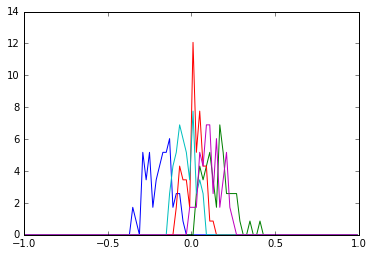

In [15]:
%matplotlib inline
for l in range(0,len(date_list_string)):
    print l
    plt.plot(bincenters_list[l],y_list[l])
plt.show()

In [ ]:






class Process(WPSProcess):


    def __init__(self):

        #
        # Process initialization
        WPSProcess.__init__(self,
            identifier       = "WPS_NDAI_DI_CAL",
            title            = "NDAI calculation process",
            abstract         = """
                               This process intend to calculate the 
                               Normalized Drought Anomaly Index (NDAI) 
                               for a specific area..
                               """,
            version          = "1.0",
            storeSupported   = True,
            statusSupported  = True)

        #
        # Adding process inputs

        self.boxIn = self.addBBoxInput(      identifier   = "bbox",
                                             title        = "Spatial region")

        self.dateIn = self.addLiteralInput(  identifier   = "date",
                                             title        = "The date to be calcualted",
                                             type         = type(''))

        #
        # Adding process outputs

        self.dataOut = self.addComplexOutput(identifier   = "map",
                                             title        = "Output NDAI image",
                                             useMapscript = True,
                                             formats      = [{'mimeType':'image/tiff'}])

    #
    # Execution part of the process
    def execute(self):

        # Get the box value
        BBOXObject = self.boxIn.getValue()
        CoordTuple = BBOXObject.coords

        #Get the date string
        date = self.dateIn.getValue()

        logging.info(CoordTuple)
        logging.info(date)

        #date='2013-06-30'
        #spl_arr=[70,30,80,50]
        spl_arr=[CoordTuple[0][0],CoordTuple[0][1],CoordTuple[1][0],CoordTuple[1][1]]

        logging.info(date)
        logging.info(spl_arr)

        ndaifn=_NDAI_CAL(date,spl_arr)
        self.dataOut.setValue( ndaifn )
        #self.textOut.setValue( self.textIn.getValue() )
        #os.remove(vcifn)
        logging.info(os.getcwd())
        return

